# Degenerate case 

This notebook describes a case with three objects with overlapping spectra.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import interpolate, integrate, sparse

import frame_optics
import spec_imager
import galaxy
import consts

import tools
import optimize
from tqdm.notebook import tqdm

import importlib

## Catalog creation

The first step is to create a list of **Galaxy** objects, which represents our galaxy catalog. In this case our objects will have H$\alpha$ fluxes above the *Euclid* flux limit, will have all the same declination *DEC* and redshift in the range 0.9-1.8. 

In [2]:
# make a catalog
seed = 3
np.random.seed(seed)

coeff = np.loadtxt('data/spectemplates.txt', skiprows=1, delimiter=',', dtype='float')
coeff = coeff[1:]

n = 3
nlines = 11
ra = np.random.uniform(-1, 1, n) * 0.01 + 1
dec = np.random.uniform(-1, 1, n) * 0.01
a = np.random.uniform(-1,1,n)-1
b = np.random.uniform(-18,-17, n)
fwhm = np.random.uniform(0.2, 1, n)
axis_ratio = np.random.uniform(0.01, 1, n)
pa = np.random.uniform(0, 180, n)
fluxes_ha=np.random.uniform(2.0,15,n)*1e-16
fluxes=np.ones((n, nlines))
for i in range(n):
    for j in range(nlines):
        fluxes[i][j]=fluxes_ha[i]*coeff[j]
        
redshift=np.random.uniform(0.9, 1.8, n)

ra[0] = 0.995
dec[0] = 0
a[0] = -1
b[0] = -17

ra[1]=1.0
ra[2]=1.005
dec[1]=0
dec[2]=0

galaxy_list = []
for i in range(n):
    galaxy_list.append(galaxy.Galaxy(
        ra=ra[i], 
        dec=dec[i], 
        continuum_params=(15000, 1e-4*a[i], b[i]), 
        fwhm_arcsec=fwhm[i],
        axis_ratio=axis_ratio[i],
        pa=pa[i],
        fluxes_emlines=fluxes[i],
        redshift=redshift[i],
        profile='gaussian', 
        nlines=nlines,
        obs_wavelength_step=300,
        obs_wavelength_range= (12500, 18500),
    ))

## Instrumental settings 

We now need to set the instrument parameters and we need to define the number of frames that will be simulated, their pointing centers and the dispersion directions. We create a list of **SpecImager** objects, with each element in this list representing one frame. 

In [3]:
# generate frames
pointing_centers = np.array([
    (3600, 0),
    (3600, 0),
    (3600, 0),
    (3600, 0)
]) / 3600 # convert arcsec to deg

grism_orientations = (0, -4, 180, 184)

npoint = len(pointing_centers)

In [4]:
frame_list = []
for i, pointing_center in enumerate(pointing_centers):
    o = frame_optics.FrameOptics(
        det_width=600,
        det_height=100,
        pointing_center=pointing_center, 
        dispersion_angle=grism_orientations[i],
        sigma2_det=1.5,
        wavelength_0=15000
    )
    frame_list.append(spec_imager.SpectralImager(o))

## Image creation

We now simulated the spectral images associated with the catalog and the frames we defined earlier. We use the **make_image** routine. 

In [5]:
images = []
for frame in frame_list:
    image, var_image = frame.make_image(galaxy_list, noise=True)
    images.append((image, var_image))

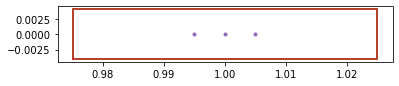

In [6]:
importlib.reload(frame_optics)

plt.subplot(111, aspect='equal')

for frame in frame_list:
    x, y = frame.optics.footprint().transpose()
    x = np.concatenate([x, [x[0]]])
    y = np.concatenate([y, [y[0]]])
    plt.plot(x, y)

plt.plot(ra, dec, ".")

  0%|          | 0/4 [00:00<?, ?it/s]

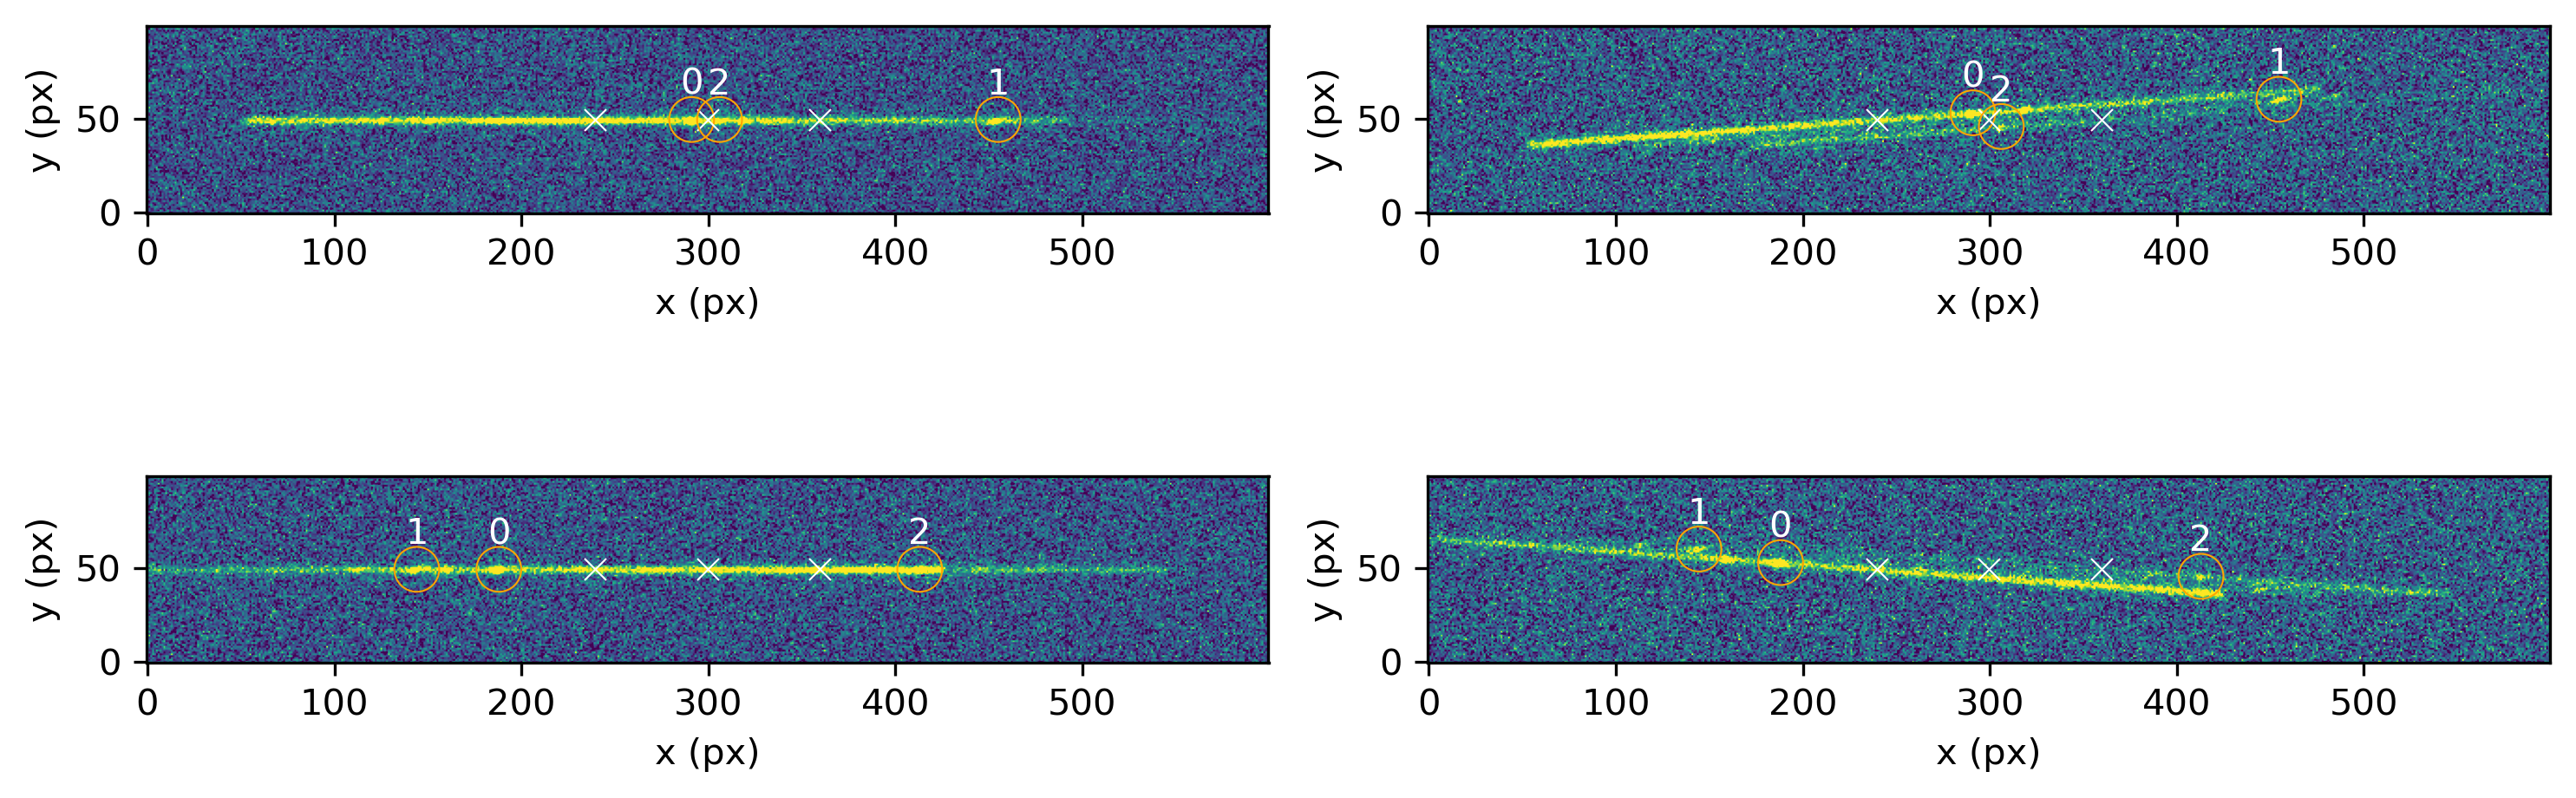

In [7]:
plt.figure(figsize=(10,4), dpi=300)

for i in tqdm(range(len(pointing_centers))):
    ax = plt.subplot(2,2,i+1)
    low, high = np.percentile(images[i][0], [10,99.])
    plt.imshow(images[i][0], vmin=low, vmax=high, cmap='viridis', origin='lower')
    for gi, g in enumerate(galaxy_list):
        x, y = frame_list[i].optics.radec_to_pixel(g.params['ra'], g.params['dec'])
        wave = (1+g.params['redshift'])*6564.61
        dx, dy = frame_list[i].optics.wavelength_to_pix(wave)
        dx0, dy0 = frame_list[i].optics.wavelength_to_pix(15000)
        plt.scatter(x, y, marker='x', c='w', linewidth=0.5)
        circ = plt.Circle((x+dx, y+dy), radius=12, edgecolor='orange', facecolor='None', linewidth=0.5)
        ax.add_patch(circ)
        label = f"{gi}"
        plt.annotate(label, # this is the text
                 (x+dx,y+dy), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,7), # distance from text to points (x,y)
                 ha='center', c='white') # horizontal alignment can be left, right or center
    ax.set_xlabel("x (px)")
    ax.set_ylabel("y (px)")
plt.tight_layout()

## Optimization - Four frames, MeasureSource routine

We now proceed to estimate the parameters of interest of the simulated galaxies (continuum SED, emission line fluxes, redshift).  

In [8]:
waves=[]
extr1ds=[]
fluxess=[]
pzs=[]
new_pzs=[]
new_redshiftss=[]
redshifts=[]
logsums=[]

mask=np.ones_like(images[0][0], dtype='bool')
mask_list=[]
mask_list.append(mask)

redshift_grid=np.arange(0.9, 1.8, 3e-3)

for i in tqdm(range(n)):
    wave, extr1d, fluxes, pz, new_pz, new_redshifts, z_est, logsum=optimize.MeasureSource(
    images=images,
    frame_list=frame_list,
    mask_list=mask_list,
    test_galaxy=galaxy_list[i].copy(),
    redshift_grid=redshift_grid,
    flux_est=True
    )
    waves.append(wave)
    extr1ds.append(extr1d)
    fluxess.append(fluxes)
    pzs.append(pz)
    new_pzs.append(new_pz)
    new_redshiftss.append(new_redshifts)
    redshifts.append(z_est)
    logsums.append(logsum)

  0%|          | 0/3 [00:00<?, ?it/s]

Computing Jacobian done (18581, 20)


  0%|          | 0/300 [00:00<?, ?it/s]

2
Refining solution...


  0%|          | 0/55 [00:00<?, ?it/s]

Computing Jacobian done (15262, 20)


  0%|          | 0/300 [00:00<?, ?it/s]

3
Refining solution...


  0%|          | 0/60 [00:00<?, ?it/s]

Computing Jacobian done (18600, 20)


  0%|          | 0/300 [00:00<?, ?it/s]

3
Refining solution...


  0%|          | 0/60 [00:00<?, ?it/s]

### Results

In [9]:
err=np.zeros(n)
print('ID', 'z_true', 'z_est', 'sigma', 'f_true', 'f_est')
for i in range(n):
    err[i]=np.abs(redshifts[i]-redshift[i])/(1+redshift[i])
    print(i, round(redshift[i], 4), round(redshifts[i],4), round(err[i],4), round(galaxy_list[i].params['fluxes_emlines'][0]*1e16), round(fluxess[i][0],2))

ID z_true z_est sigma f_true f_est
0 1.3902 1.3901 0.0 11 10.73
1 1.6023 1.6031 0.0003 8 7.56
2 1.1757 1.1759 0.0001 4 4.02


## Optimization - Four frames, MeasureEverything routine

In [10]:
mask=np.ones_like(images[0][0], dtype='bool')
mask_list=[]
mask_list.append(mask)

redshift_grid=np.arange(0.9, 1.8, 3e-3)

g2=[]
for i in range(3):
    g2.append(galaxy_list[i].copy())

Wave, Extr1d, Fluxes, Pz, New_pz, Logsum, New_redshifts, Z_est=optimize.MeasureEverything(
    images=images,
    frame_list=frame_list,
    mask_list=mask_list,
    galaxy_list=g2,
    redshift_grid=redshift_grid,
    flux_est=True
    )

Computing Jacobian done (29504, 60)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

2
Refining solution...


  0%|          | 0/55 [00:00<?, ?it/s]

Estimating line fluxes...


  0%|          | 0/300 [00:00<?, ?it/s]

3
Refining solution...


  0%|          | 0/60 [00:00<?, ?it/s]

Estimating line fluxes...


  0%|          | 0/300 [00:00<?, ?it/s]

2
Refining solution...


  0%|          | 0/55 [00:00<?, ?it/s]

Estimating line fluxes...


### Results

In [11]:
Err=np.zeros(n)
print('ID', 'z_true', 'z_est', 'sigma', 'f_true', 'f_est')
for i in range(n):
    Err[i]=np.abs(Z_est[i]-redshift[i])/(1+redshift[i])
    print(i, redshift[i], round(Z_est[i],4), round(err[i],4), round(galaxy_list[i].params['fluxes_emlines'][0]*1e16,2), round(Fluxes[i][0],2))

ID z_true z_est sigma f_true f_est
0 1.3901841162286603 1.3901 0.0 11.01 10.67
1 1.6022832880602302 1.6025 0.0003 7.73 7.76
2 1.1757271791385617 1.1753 0.0001 4.04 4.05


## Optimization - One frame, MeasureSource routine

In [12]:
waves1=[]
extr1ds1=[]
fluxess1=[]
pzs1=[]
new_pzs1=[]
new_redshiftss1=[]
redshifts1=[]
logsums1=[]

redshift_grid=np.arange(0.9, 1.8, 3e-3)

for j in tqdm(range(len(frame_list))):
    
    frame_list1=[]
    frame_list1.append(frame_list[j])
    images1=[]
    images1.append(images[j])
    
    mask=np.ones_like(images1[0][0], dtype='bool')
    mask_list=[]
    mask_list.append(mask)
    
    for i in tqdm(range(n)):
        wave, extr1d, fluxes, pz, new_pz, new_redshifts, z_est, logsum=optimize.MeasureSource(
        images=images1,
        frame_list=frame_list1,
        mask_list=mask_list,
        test_galaxy=galaxy_list[i].copy(),
        redshift_grid=redshift_grid,
        flux_est=True
        )
        waves1.append(wave)
        extr1ds1.append(extr1d)
        fluxess1.append(fluxes)
        pzs1.append(pz)
        new_pzs1.append(new_pz)
        new_redshiftss1.append(new_redshifts)
        redshifts1.append(z_est)
        logsums1.append(logsum)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Computing Jacobian done (4779, 20)


  0%|          | 0/300 [00:00<?, ?it/s]

2
Refining solution...


  0%|          | 0/55 [00:00<?, ?it/s]

Computing Jacobian done (3696, 20)


  0%|          | 0/300 [00:00<?, ?it/s]

Reduced number of redshifts with refined grid from 6 to 5
5
Refining solution...


  0%|          | 0/115 [00:00<?, ?it/s]

Computing Jacobian done (4221, 20)


  0%|          | 0/300 [00:00<?, ?it/s]

2
Refining solution...


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Computing Jacobian done (5097, 20)


  0%|          | 0/300 [00:00<?, ?it/s]

2
Refining solution...


  0%|          | 0/55 [00:00<?, ?it/s]

Computing Jacobian done (3942, 20)


  0%|          | 0/300 [00:00<?, ?it/s]

3
Refining solution...


  0%|          | 0/60 [00:00<?, ?it/s]

Computing Jacobian done (4503, 20)


  0%|          | 0/300 [00:00<?, ?it/s]

2
Refining solution...


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Computing Jacobian done (4212, 20)


  0%|          | 0/300 [00:00<?, ?it/s]

2
Refining solution...


  0%|          | 0/55 [00:00<?, ?it/s]

Computing Jacobian done (3689, 20)


  0%|          | 0/300 [00:00<?, ?it/s]

3
Refining solution...


  0%|          | 0/60 [00:00<?, ?it/s]

Computing Jacobian done (4779, 20)


  0%|          | 0/300 [00:00<?, ?it/s]

Reduced number of redshifts with refined grid from 6 to 5
5
Refining solution...


  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Computing Jacobian done (4493, 20)


  0%|          | 0/300 [00:00<?, ?it/s]

2
Refining solution...


  0%|          | 0/55 [00:00<?, ?it/s]

Computing Jacobian done (3935, 20)


  0%|          | 0/300 [00:00<?, ?it/s]

3
Refining solution...


  0%|          | 0/60 [00:00<?, ?it/s]

Computing Jacobian done (5097, 20)


  0%|          | 0/300 [00:00<?, ?it/s]

2
Refining solution...


  0%|          | 0/55 [00:00<?, ?it/s]

### Results

In [13]:
err2=np.zeros(n*len(frame_list))

for j in range(len(frame_list)):
    print('Frame: ', frame_list[j].optics.params['dispersion_angle'])
    print('ID', 'z_true', 'z_est', 'sigma', 'f_true', 'f_est')
    for i in range(n):
        k=i+3*j
        err2[i]=np.abs(redshifts1[k]-redshift[i])/(1+redshift[i])
        print(i, redshift[i], round(redshifts1[k],4), round(err2[i],4), round(galaxy_list[i].params['fluxes_emlines'][0]*1e16,2), round(fluxess1[k][0],2))

Frame:  0
ID z_true z_est sigma f_true f_est
0 1.3901841162286603 1.3901 0.0 11.01 10.91
1 1.6022832880602302 1.2692 0.128 7.73 16.08
2 1.1757271791385617 1.1471 0.0131 4.04 10.38
Frame:  -4
ID z_true z_est sigma f_true f_est
0 1.3901841162286603 1.3901 0.0 11.01 11.09
1 1.6022832880602302 1.6031 0.0003 7.73 9.4
2 1.1757271791385617 1.1765 0.0003 4.04 5.45
Frame:  180
ID z_true z_est sigma f_true f_est
0 1.3901841162286603 1.3895 0.0003 11.01 9.94
1 1.6022832880602302 1.5116 0.0349 7.73 12.08
2 1.1757271791385617 1.7252 0.2525 4.04 3.94
Frame:  184
ID z_true z_est sigma f_true f_est
0 1.3901841162286603 1.3901 0.0 11.01 10.96
1 1.6022832880602302 1.6019 0.0001 7.73 7.35
2 1.1757271791385617 1.1753 0.0002 4.04 4.45


## Plots 

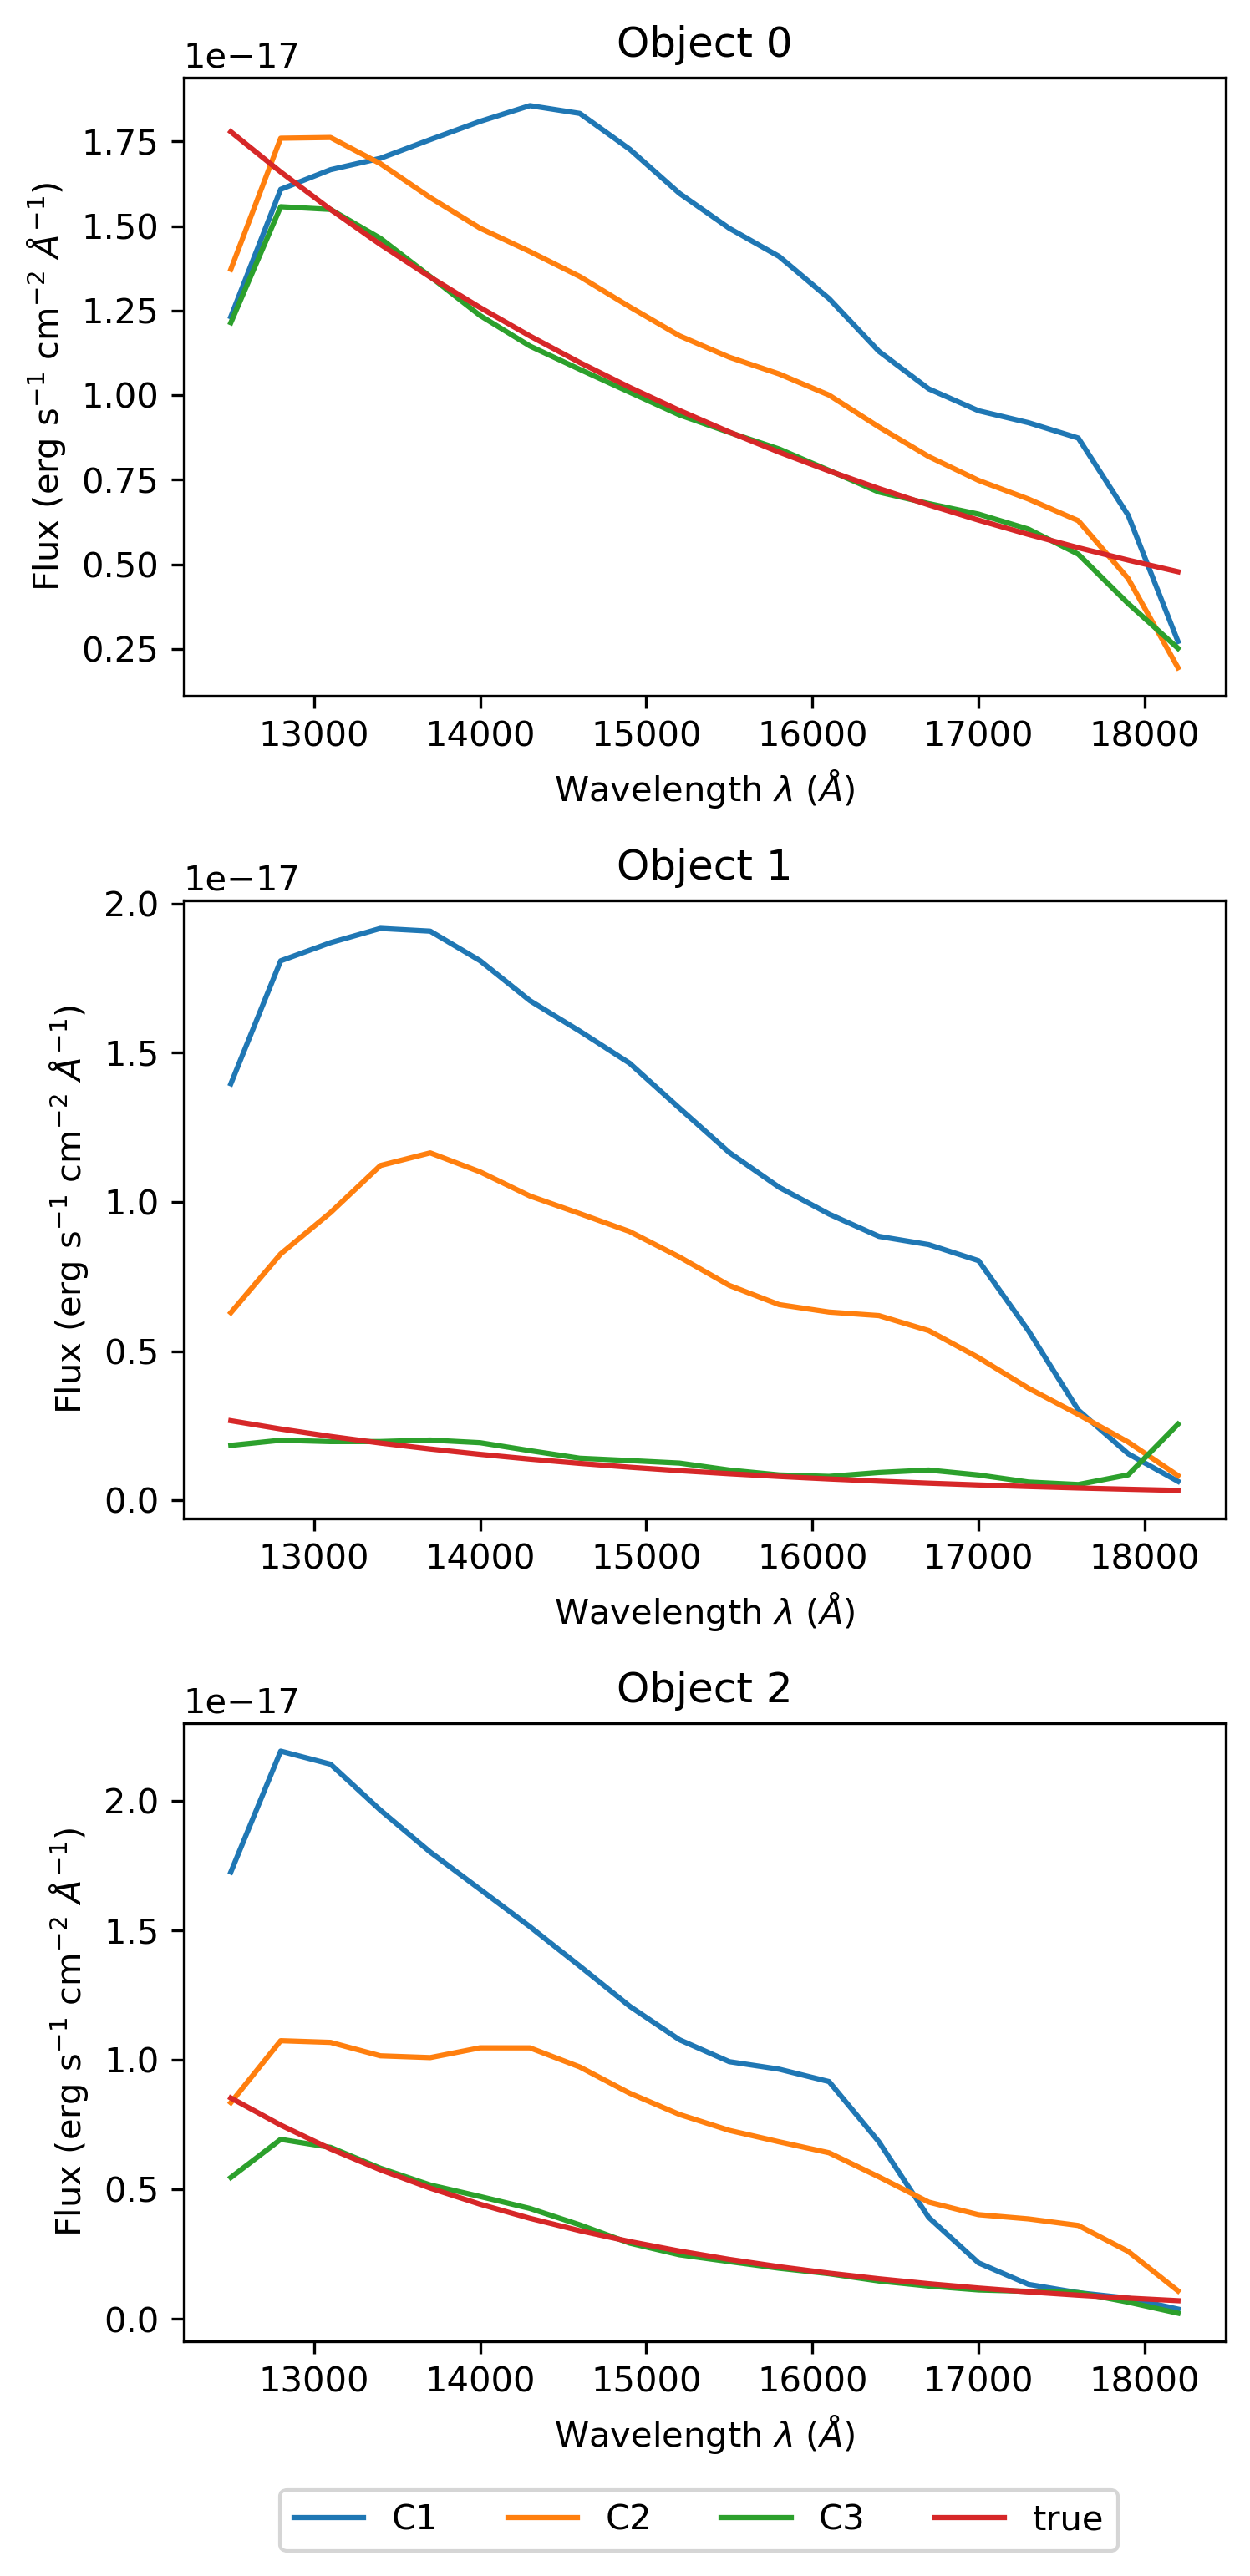

In [14]:
labels=('C1', 'C2', 'C3', 'true')
fig=plt.figure(figsize=(5,10), dpi=300)
plt.subplot(3,1,1)
plt.plot(waves1[0],extr1ds1[0]*1e-18, label='C1')
plt.plot(waves[0], extr1ds[0]*1e-18, label='C2')
plt.plot(Wave, Extr1d[0]*1e-18, label='C3')
plt.plot(Wave, galaxy_list[0].sed(Wave), label='true')
plt.title('Object 0')
plt.xlabel(r'Wavelength $\lambda$ $(\AA)$')
plt.ylabel(r'Flux (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')
plt.subplot(3,1,2)
plt.plot(waves1[1],extr1ds1[1]*1e-18, label='C1')
plt.plot(waves[1], extr1ds[1]*1e-18, label='C2')
plt.plot(Wave, Extr1d[1]*1e-18, label='C3')
plt.plot(Wave, galaxy_list[1].sed(Wave))
plt.xlabel(r'Wavelength $\lambda$ $(\AA)$')
plt.ylabel(r'Flux (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')
plt.title('Object 1')
plt.subplot(3,1,3)
plt.plot(waves1[2],extr1ds1[2]*1e-18)
plt.plot(waves[2], extr1ds[2]*1e-18)
plt.plot(Wave, Extr1d[2]*1e-18)
plt.plot(Wave, galaxy_list[2].sed(Wave))
plt.xlabel(r'Wavelength $\lambda$ $(\AA)$')
plt.ylabel(r'Flux (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')
plt.title('Object 2')
fig.legend(labels, loc='lower center', bbox_to_anchor=(0.55,-0.03), ncol=len(labels), bbox_transform=fig.transFigure)
plt.tight_layout()

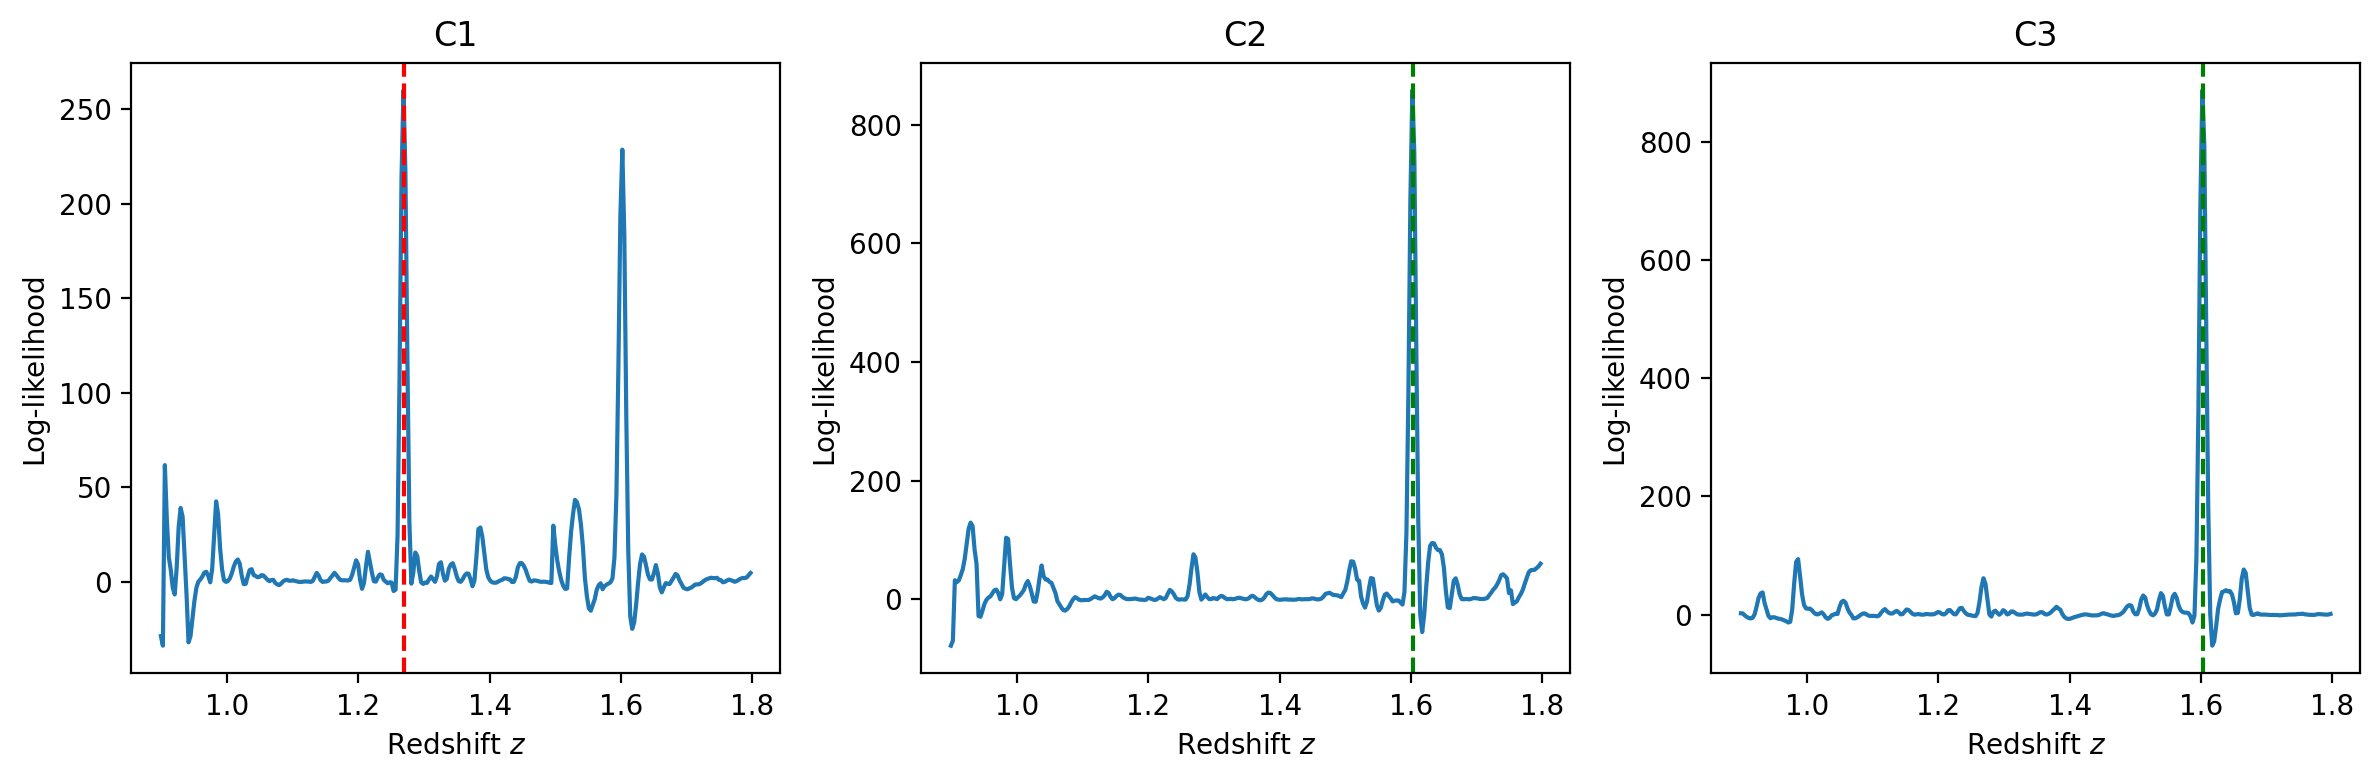

In [15]:
k=1

plt.figure(figsize=(12,4), dpi=200)
plt.subplot(1,3,1)
plt.plot(redshift_grid, pzs1[k])
plt.axvline(redshifts1[k], linestyle='--', color='red')
plt.title('C1')
plt.xlabel(r'Redshift $z$')
plt.ylabel(r'Log-likelihood')
plt.subplot(1,3,2)
plt.plot(redshift_grid, pzs[k])
plt.axvline(redshifts[k], linestyle='--', color='green')
plt.xlabel(r'Redshift $z$')
plt.ylabel(r'Log-likelihood')
plt.title('C2')
plt.subplot(1,3,3)
plt.plot(redshift_grid, Pz[k])
plt.axvline(Z_est[k], linestyle='--', color='green')
plt.xlabel(r'Redshift $z$')
plt.ylabel(r'Log-likelihood')
plt.title('C3')
plt.tight_layout()

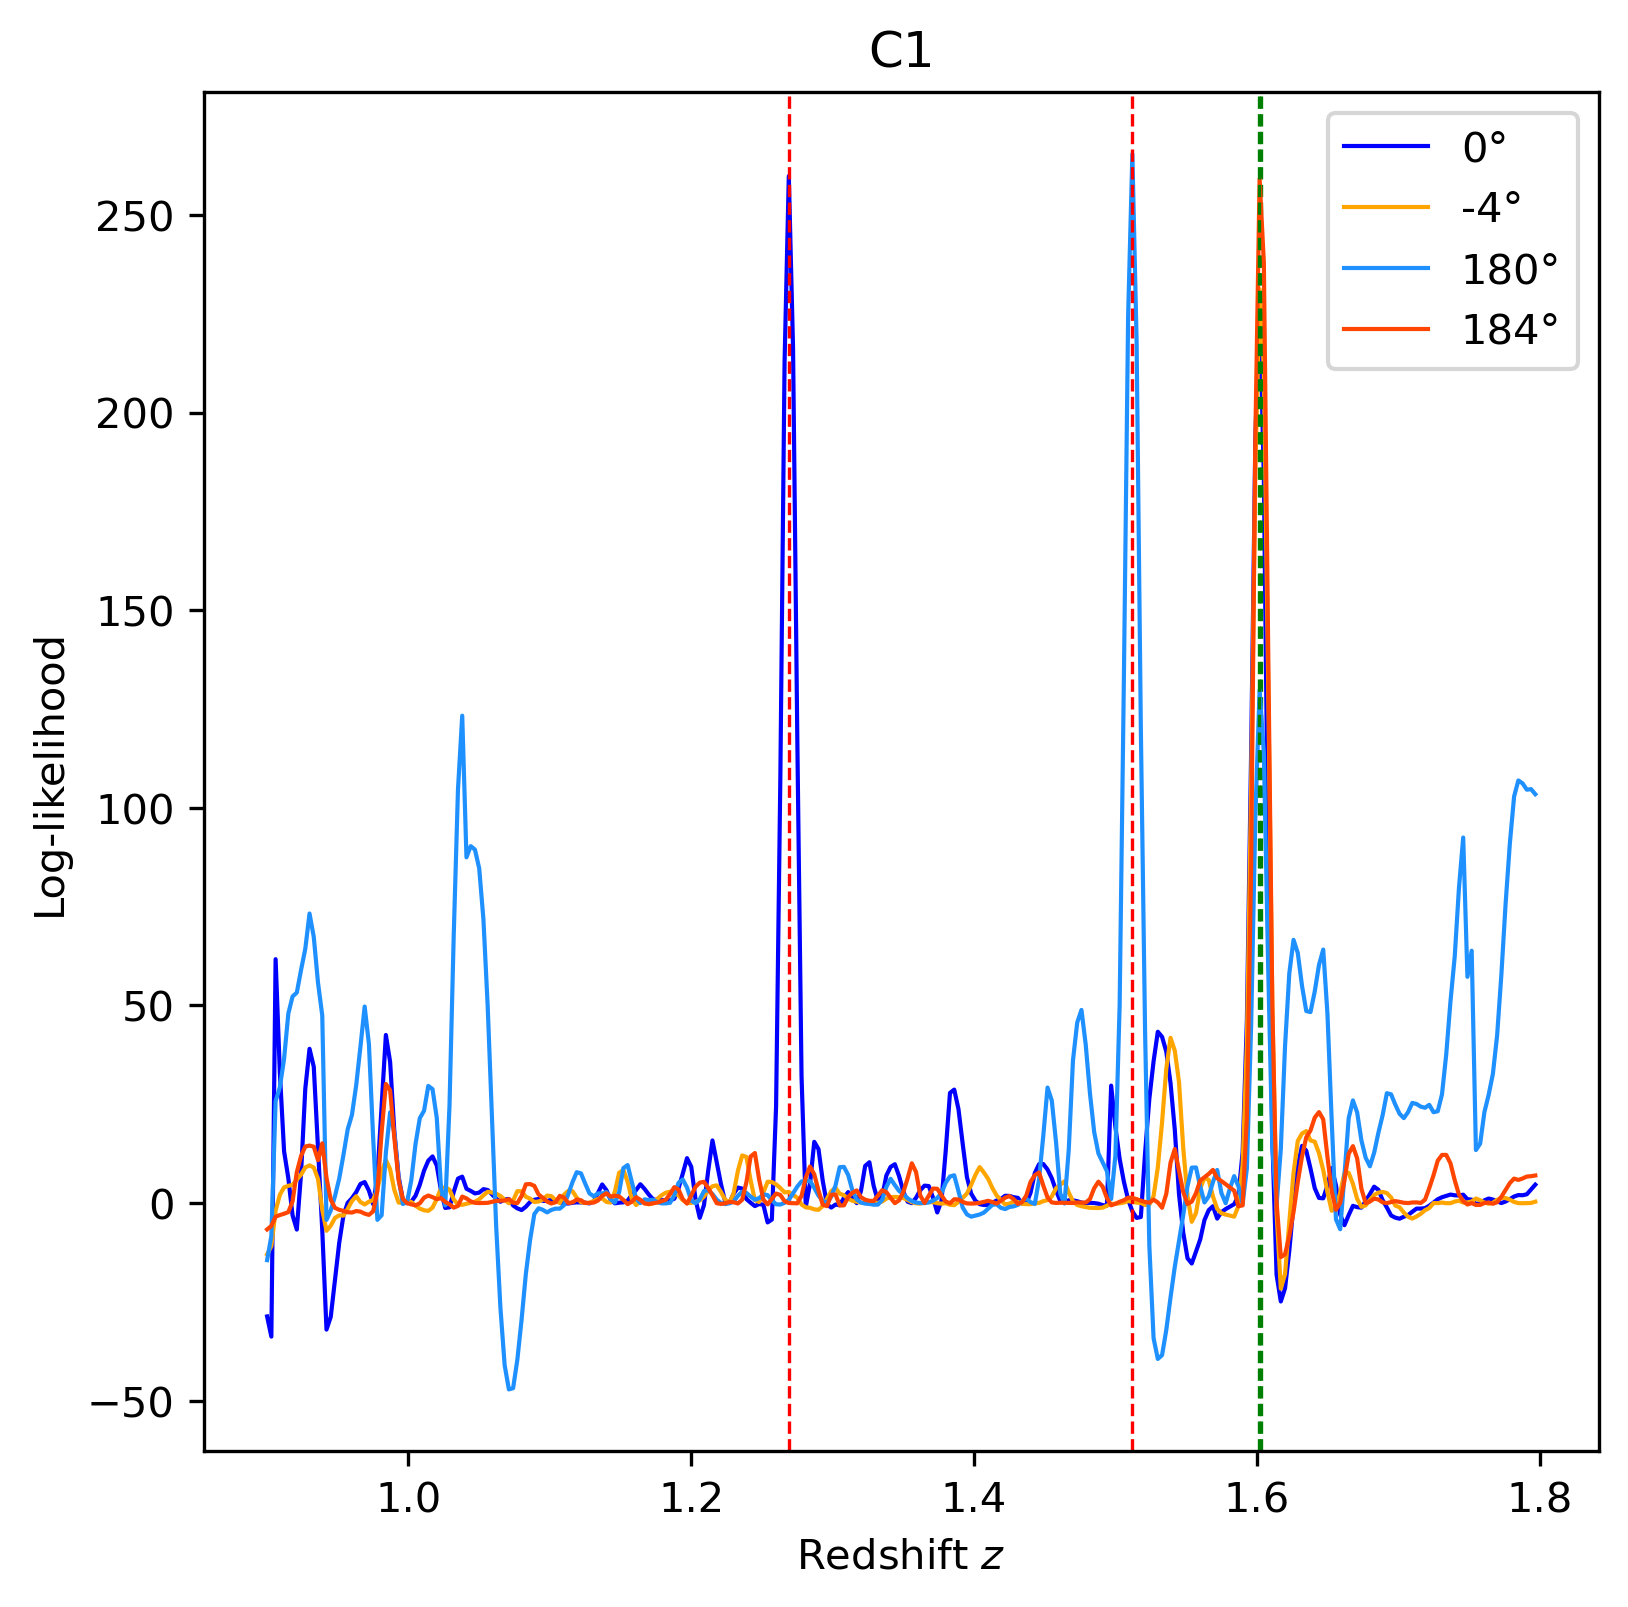

In [16]:
plt.figure(figsize=(6,6), dpi=300)
colors=['blue', 'orange', 'dodgerblue', 'orangered']
labels=['0°', '-4°', '180°', '184°']
colors2=['red', 'green', 'red', 'green']
for i in range(len(frame_list)):
    j=k+3*i
    plt.plot(redshift_grid, pzs1[j], label=labels[i], linewidth=1, color=colors[i])
    plt.axvline(redshifts1[j], linestyle='--', color=colors2[i],linewidth=0.8)
plt.title('C1')
plt.xlabel(r'Redshift $z$')
plt.ylabel(r'Log-likelihood')
plt.legend()